# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [3]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [4]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [5]:
def Q1(num_examples=5):
    ### STUDENT START ###
    
    train_ex = newsgroups_train.target_names
    
    # printing only first examples in the train_data
    for i in range (num_examples):
        print("### EXAMPLE {} for {}".format(i+1, train_ex[train_labels[i]]))
        print(train_data[i])
        print("      ")
    
    
    ### STUDENT END ###

Q1(5)

### EXAMPLE 1 for comp.graphics
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
      
### EXAMPLE 2 for talk.religion.misc


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption


### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [13]:
def Q2():
    ### STUDENT START ###
    
    # 1. Transform the training data into a matrix of word unigram feature vectors.
    cv1 = CountVectorizer() # initialize CountVectorizer 
    v1_train = cv1.fit_transform(train_data) # fit_transform for train_data
    print("Q1:")
    print("vocabulary size: ", v1_train.shape[1])
    print("avg # of non-zero features per example: ", v1_train.nnz / float(v1_train.shape[0]))
    print("fraction of the non-zero entries in the matrix: ", v1_train.nnz / (float(v1_train.shape[0]*float(v1_train.shape[1]))))
    print("feature strings (in alphabetical order): 0th is '{}', last is '{}'".format(cv1.get_feature_names()[0], cv1.get_feature_names()[-1]))
    
    # 2. Transform the training data into a matrix of word unigram feature vectors 
    #restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the size of the vocabulary.
    vocab = ["atheism", "graphics", "space", "religion"]
    cv2 = CountVectorizer(vocabulary = vocab)
    v2_train = cv2.fit_transform(train_data)
    print("\nQ2:")
    print("vocabulary: ", cv2.vocabulary_)
    print("vocabulary size: ", v2_train.shape[1])
    print("average number of non-zero features per example: ", v2_train.nnz / float(v2_train.shape[0]))
    
    # 3. Transform the training data into a matrix of character bigram and trigram feature vectors.
    # bigram
    cv3_b = CountVectorizer(ngram_range=(2,2),analyzer='char')
    v3_train_b = cv3_b.fit_transform(train_data)
    print("\nQ3:")
    print("character bigram matrix vocabulary size: ", v3_train_b.shape[1])
    # trigram
    cv3_t = CountVectorizer(ngram_range=(3,3),analyzer='char')
    v3_train_t = cv3_t.fit_transform(train_data)
    print("character trigram matrix vocabulary size: ", v3_train_t.shape[1])
    
    # 4. Transform the training data into a matrix of word unigram feature vectors and prune words that appear in fewer than 10 documents.
    cv4 = CountVectorizer(ngram_range=(1,1), min_df=10)
    v4_train = cv4.fit_transform(train_data)
    print("\nQ4:")
    print("vocabulary size when min_df=10: ", v4_train.shape[1])
    
    # 5. Transform the training data into a matrix of word unigram feature vectors.
    
    # train data
    cv5_train = CountVectorizer()
    v5_train = cv5_train.fit_transform(train_data)
    
    # dev data
    cv5_dev = CountVectorizer()
    v5_dev = cv5_dev.fit_transform(dev_data)
    
    # words included in vocabulary for train and dev data 
    train_words = set(cv5_train.vocabulary_.keys())
    dev_words = set(cv5_dev.vocabulary_.keys())
    
    ratio = (1.0 * len(dev_words) - len(train_words.intersection(dev_words))) / len(dev_words)
    print("\nQ5:")
    print("fraction of words in the development vocabulary that is missing from the training vocabulary: ", ratio)
    
    ### STUDENT END ###

Q2()

Q1:
vocabulary size:  26879
avg # of non-zero features per example:  96.70599803343165
fraction of the non-zero entries in the matrix:  0.0035978272269590263
feature strings (in alphabetical order): 0th is '00', last is 'zyxel'

Q2:
vocabulary:  {'atheism': 0, 'graphics': 1, 'space': 2, 'religion': 3}
vocabulary size:  4
average number of non-zero features per example:  0.26843657817109146

Q3:
character bigram matrix vocabulary size:  3291
character trigram matrix vocabulary size:  32187

Q4:
vocabulary size when min_df=10:  3064

Q5:
fraction of words in the development vocabulary that is missing from the training vocabulary:  0.24787640034470024


### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [36]:
def Q3():
    ### STUDENT START ###
    
    # 1. Transform the training and development data to matrices of word unigram feature vectors.
    cv1 = CountVectorizer()
    v_train = cv1.fit_transform(train_data)
    v_dev = cv1.transform(dev_data)
    
    # 2. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score. 
    #For each model, show the k value and f1 score.
    f1_knn = []
    num_models = 10
    # loop to create KNN models and store accuracies 
    for k in range(1, num_models+1):
        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_model.fit(v_train, train_labels)
        f1_knn.append(metrics.f1_score(dev_labels, knn_model.predict(v_dev), average="weighted"))
    # dataframe to print out key stats for each KNN model
    df_KNN = pd.DataFrame({"k": range(1, num_models+1), "f1": f1_knn})
    print("Q2: KNN model f1_scores")
    print(df_KNN)
    
    # 3. Produce several Naive Bayes models by varying smoothing (alpha), 
    #including one with alpha set approximately to optimize f1 score. For each model, show the alpha value and f1 score.
    f1_nb = []
    alpha_nb = [0.009, 0.01, 0.05, 0.051, 0.06, 0.065, 0.067, 0.070, 0.071, 0.072, 0.1, 0.12, 0.2]
    # loop to create NB models and store accuracies
    for alpha in alpha_nb:
        nb = MultinomialNB(alpha=alpha)
        nb.fit(v_train, train_labels)
        f1_nb.append(metrics.f1_score(dev_labels, nb.predict(v_dev), average="weighted"))
    # dataframe to print
    df_nb = pd.DataFrame({"alpha": alpha_nb, "f1":f1_nb})
    print("\nQ3: Naive Bayes model f1_scores")
    print(df_nb)
    
    # 4. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score. 
    #For each model, show the C value, f1 score, and sum of squared weights for each topic.
    f1_LR = []
    c_LR = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    # loop to run Logistic Regression for diff c-values
    topic_weights = np.empty((0, len(newsgroups_train.target_names)))
    for c in c_LR:
        LR = LogisticRegression(C=c, solver="liblinear", multi_class="auto")
        # fit and get f1 score
        LR.fit(v_train, train_labels)
        f1_LR.append(metrics.f1_score(dev_labels, LR.predict(v_dev), average="weighted"))
        # sum of squared weights for each topic
        weights = (LR.coef_**2).sum(1)
        topic_weights = np.r_[topic_weights, [np.array(weights)]]
        
    # dataframe to print
    df_LR = pd.DataFrame({"c": c_LR, "f1": f1_LR})
    i = 0
    for topic in newsgroups_train.target_names:
        df_LR[topic] = topic_weights[:,i]
        i += 1
    print("\nQ4: Logistic Regression models")
    print(df_LR)

    ### STUDENT END ###

Q3()

Q2: KNN model f1_scores
    k        f1
0   1  0.380503
1   2  0.380542
2   3  0.408415
3   4  0.403123
4   5  0.428761
5   6  0.446665
6   7  0.450479
7   8  0.446984
8   9  0.436567
9  10  0.427850

Q3: Naive Bayes model f1_scores
    alpha        f1
0   0.009  0.775166
1   0.010  0.775166
2   0.050  0.785856
3   0.051  0.785856
4   0.060  0.786201
5   0.065  0.786315
6   0.067  0.786315
7   0.070  0.786315
8   0.071  0.786315
9   0.072  0.786315
10  0.100  0.790305
11  0.120  0.788547
12  0.200  0.787630

Q4: Logistic Regression models
       c        f1  alt.atheism  comp.graphics   sci.space  talk.religion.misc
0    0.1  0.696624    27.126986      24.665612   27.459314           23.026465
1    0.2  0.705873    49.743223      42.749898   49.330854           42.666045
2    0.3  0.710085    69.295658      57.861244   67.907191           59.780004
3    0.4  0.708282    86.749557      71.154355   84.281757           75.045820
4    0.5  0.708474   102.608342      83.102297   99.031914  

ANSWER: 

Why doesn't k-Nearest Neighbors work well for this problem?
**Because of the curse of dimensionality and the kNN classifier model assumes that similar points share similar labels/positions. Since in higher dimensional spaces the points are drawn from a probability distribution with multiple dimensions, the points do not tned to be close together.**

Why doesn't Logistic Regression work as well as Naive Bayes does?
**Logistic Regression models may be more sensitive to outliers, which may cause the Naive Bayes to do better — depending on the dataset.**

What is the relationship between logistic regression's sum of squared weights vs. C value?
**The c-value is equal to 1/lambda, where lambda is the regularization parameter. A larger lambda leads to adding bigger weights in the loss function (resulting in underfitting), so the higher the c, the lower the lambda, and therefore a lower penalty to the loss function.**


### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [39]:
def Q4():
    ### STUDENT START ###
    
    # 1. Transform the data to a matrix of word bigram feature vectors. 
    cv = CountVectorizer(ngram_range = (2,2))
    v_train = cv.fit_transform(train_data)
    v_dev = cv.transform(dev_data)
    
    # Produce a Logistic Regression model.
    LR = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    LR.fit(v_train, train_labels)
    
    # 2. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
    f_set = set() # get only unique features
    for i in range(LR.coef_.shape[0]):
        # lists to store top weights and features
        f_list = []
        coef_list = []
        # another loop to find highest ranked feature, and store name + coefficient
        for f in sorted(range(len(LR.coef_[i])), key=lambda x: LR.coef_[i][x], reverse=True)[:5]:
            f_list.append(str(np.array(cv.get_feature_names())[f]))
            coef_list.append(float(LR.coef_[i][f]))
        f_set = f_set.union(f_list)
        print("Top 5 features for", newsgroups_train.target_names[i])
        print(f_list)
        print(coef_list)
    
    # 3. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
    f_set = list(f_set)
    df = pd.DataFrame() # initalize dataframe
    df["Top Features"] = f_set # store top features in dataframe
    # for each topic, add coefficients to dataframe
    i = 0
    for t in newsgroups_train.target_names:
        df[t] = LR.coef_[i][[cv.vocabulary_[z] for z in f_set]]
    print("\n20 row (features) x 4 column (topics) table of the weights:")
    print(df)
    
    # only 19 features in df because "cheers kent" in top five features for alt.atheism and talk.religion.misc
    # edit later.
    
    
    
    ### STUDENT END ###

Q4()

Top 5 features for alt.atheism
['claim that', 'cheers kent', 'was just', 'you are', 'are you']
[0.605548549829918, 0.5557194633105557, 0.4820504211026891, 0.47274071300428827, 0.44695366863502217]
Top 5 features for comp.graphics
['looking for', 'in advance', 'comp graphics', 'out there', 'is there']
[1.1083703256045523, 0.8325643308172914, 0.8012152230547809, 0.7586775841277474, 0.754975521326169]
Top 5 features for sci.space
['the space', 'the moon', 'sci space', 'and such', 'it was']
[0.8711649600167557, 0.8312273979987368, 0.6211354224562932, 0.5905568156222766, 0.5253471298059617]
Top 5 features for talk.religion.misc
['the fbi', 'cheers kent', 'ignorance is', 'but he', 'of jesus']
[0.551996652454611, 0.5348275963516955, 0.5043106802231775, 0.49187633500077493, 0.42374395551696237]

20 row (features) x 4 column (topics) table of the weights:
     Top Features  alt.atheism  comp.graphics  sci.space  talk.religion.misc
0   comp graphics    -0.292166      -0.292166  -0.292166        

Do you see any surprising features in this table?
ANSWER: Highest ranked features for each topic have a positive coefficient, but the coefficient is negative for other topics, which may suggest that each of the top five words are unique for each topic. 

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [38]:
def identityfxn(x):
    """identify function"""
    return x

In [46]:
def preprocess(x):
    x = x.lower()
    x = re.sub('\d+', 'NUM', x) #replace any digit with word "NUM"
    x = re.sub('[^(a-zNUM)]', ' ',x) #replace any sequence starting with letters and NUM with blank
    x = ' '.join([y[:5] for y in x.split()]) #split and join only the first 4 characters of each word
    return(x)

In [47]:
def Q5():
    ### STUDENT START ###
    
    # 1. Produce a Logistic Regression model (with no preprocessing of text). 
    cv = CountVectorizer(preprocessor=identityfxn)
    v_train = cv.fit_transform(train_data)
    v_dev = cv.transform(dev_data)
    
    LR_1 = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    LR_1.fit(v_train, train_labels)
    print("LR no preprocessing: f1_score = {}, size of vocab = {}".format(metrics.f1_score(dev_labels, LR_1.predict(v_dev), average="weighted"), 
                                                                         v_train.shape[1]))
    
    # 2. Produce an improved Logistic Regression model by preprocessing the text. 
    cv_2 = CountVectorizer(preprocessor=preprocess)
    v2_train = cv_2.fit_transform(train_data)
    v2_dev = cv_2.transform(dev_data)
    
    LR_2 = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    LR_2.fit(v2_train, train_labels)
    print("LR with preprocessing: f1_score = {}, size of vocab = {}".format(metrics.f1_score(dev_labels, LR_2.predict(v2_dev), average="weighted"), 
                                                                           v2_train.shape[1]))
    
    
    ### STUDENT END ###

Q5()

LR no preprocessing: f1_score = 0.7069109185493502, size of vocab = 33291
LR with preprocessing: f1_score = 0.7259792825450058, size of vocab = 15046


In [48]:
33291 - 15046

18245

After preprocessing, the f1_score improved to 0.7259792825450058 while the size of the vocabulary decreased to 15046 (decreased by 18245).

### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


F1 score for models:
       c  vocab_size     F1_L1  vocab_reduced  F1_L1_reduced  F1_L2_reduced
0  0.001       26879  0.244928              1       0.184192       0.230184
1  0.010       26879  0.422068             12       0.405649       0.422902
2  0.100       26879  0.649347            147       0.627724       0.642203
3  0.200       26879  0.693600            263       0.662835       0.669202
4  0.400       26879  0.700392            470       0.677777       0.670328
5  0.600       26879  0.694524            609       0.675470       0.683544
6  1.000       26879  0.696850            754       0.691118       0.692861
7  1.100       26879  0.690475            833       0.684291       0.684069
8  1.500       26879  0.699858            872       0.687153       0.693102


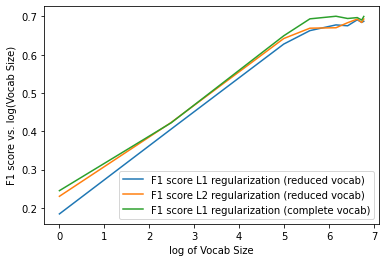

In [58]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    
    # store f1_score, vocab size and reduced vocabulary for Linear Regression models
    #complete vocab
    name = []
    f1_score = []
    vocab_size = []
    reduced_vocab = []
    #reduced vocab
    name_l1 = []
    f1_l1 = []
    vocab_l1 = []
    name_l2 = []
    f1_l2 = []
    vocab_l2 = []
    
    # loop for Linear Regression models 
    c_list = [0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 1, 1.1, 1.5]
    for c in c_list:
        # L1 regualization with complete vocab
        cv = CountVectorizer()
        v_train = cv.fit_transform(train_data)
        v_dev = cv.transform(dev_data)
        LR_1 = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty='l1', tol=0.015)
        LR_1.fit(v_train, train_labels)
        #store info
        name.append("L1")
        f1_score.append(metrics.f1_score(dev_labels, LR_1.predict(v_dev), average="weighted"))
        vocab_size.append(v_train.shape[1])
        
        ### reduce vocab (Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.)
        set_zeros = set()
        for i in range(len(newsgroups_train.target_names)):
            temp = np.where(LR_1.coef_[i]!=0)
            if len(set_zeros) == 0:
                set_zeros = temp
        else:
            if type(set_zeros) != set:
                set_zeros = set(set_zeros[0])
            if type(temp) != set:
                temp = set(temp[0])
            set_zeros = set_zeros.union(temp)
        new_vocab = []
        for key,value in cv.vocabulary_.items():
            if value in set_zeros:
                new_vocab.append(key)
        reduced_vocab.append(len(new_vocab))
        
        # L1 - reduced vocab 
        cv_l1 = CountVectorizer(vocabulary = new_vocab)
        v_train = cv_l1.fit_transform(train_data)
        v_dev = cv_l1.transform(dev_data)
        LR_2 = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty='l1', tol=0.015)
        LR_2.fit(v_train, train_labels)
        name_l1.append("L1_reduced")
        f1_l1.append(metrics.f1_score(dev_labels, LR_2.predict(v_dev), average="weighted"))
        vocab_l1.append(v_train.shape[1])
        
        # L2 - reduced vocab
        cv_l2 = CountVectorizer(vocabulary = new_vocab)
        v_train = cv_l2.fit_transform(train_data)
        v_dev = cv_l2.transform(dev_data)
        LR_3 = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty='l2', tol=0.015)
        LR_3.fit(v_train, train_labels)
        name_l2.append("L2_reduced")
        f1_l2.append(metrics.f1_score(dev_labels, LR_3.predict(v_dev), average="weighted"))
        vocab_l2.append(v_train.shape[1])
        
    # create dataframe
    df = pd.DataFrame({"c": c_list, "vocab_size": vocab_size, "F1_L1": f1_score, "vocab_reduced": vocab_l1, "F1_L1_reduced": f1_l1, "F1_L2_reduced": f1_l2})
    print("F1 score for models:")
    print(df)
    
    # graph
    fig, axs = plt.subplots(nrows=1, ncols=1)
    axs.plot(np.log(df["vocab_reduced"]), df["F1_L1_reduced"], label = "F1 score L1 regularization (reduced vocab)")
    axs.plot(np.log(df["vocab_reduced"]), df["F1_L2_reduced"], label = "F1 score L2 regularization (reduced vocab)")
    axs.plot(np.log(df["vocab_reduced"]), df["F1_L1"], label = "F1 score L1 regularization (complete vocab)")
    axs.set_xlabel("log of Vocab Size")
    axs.set_ylabel("F1 score vs. log(Vocab Size)")
    axs.legend()
    
    
    ### STUDENT END ###

Q6()

ANSWER: Using the complete vocabulary seems to perform better than using a reduced vocabulary with both L1 and L2 regularizations; however, compared to L1 reduced vocab, the L2 performs better. 

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [68]:
def Q7():
    ### STUDENT START ###
    
    cv = TfidfVectorizer()
    v_train = cv.fit_transform(train_data)
    v_dev = cv.transform(dev_data)
    
    LR = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    LR.fit(v_train, train_labels)
    predictions = LR.predict(v_dev)
    print("F1 score of Logistic Regression: ", metrics.f1_score(dev_labels, predictions, average="weighted"))
    
    pred_prob = LR.predict_proba(v_dev)
    
    r_ratios = []
    i = 0
    for p in pred_prob:
        max_p = p.max()
        max_topic = np.where(p == max_p)
        r_ratios.append(max_p / p[dev_labels[i]])
        i +=1
    
    highest_docs = sorted(range(len(r_ratios)), key=lambda i: r_ratios[i], reverse=True)[:3]
    for i in highest_docs:
        print("\n### Document number: ", i)
        print("correct topic: ", newsgroups_train.target_names[dev_labels[i]])
        print("predicted topic: ", newsgroups_train.target_names[predictions[i]])
        print("R ratio: ", r_ratios[i])
        print(" -- ")
        print(dev_data[i])
    
    
    
    
    ### STUDENT END ###

Q7()

F1 score of Logistic Regression:  0.7597662427853104

### Document number:  215
correct topic:  talk.religion.misc
predicted topic:  comp.graphics
R ratio:  929.3578934957275
 -- 
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charg

ANSWER: 

1. Whereas CountVectorizer counts the number of times a word appears in the document (which may bias frequent words and penalize rare words), TfidfVectorizer looks at the overall document weight of the word and normalizes the count based on the frequency of the word. 

3. The R ratio describes the relationship between the probability used to classify a document and the predicted probability of its correct label. If the model correctly classifies the document, the R ratio would be one. 

4. The model seems to give a lot of weight to computer related words, even though the documents are on religious topics. So, to account for these errors, you would have to increase the weight of "mormon" for the documents related to religion. 

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.